# <b>CS156 (Introduction to AI), Fall 2022</b>
# <u><b>Homework 10 submission</b></u>

### Roster Name: Rohan Athalye
### Student ID: 014099982
### Email address: rohan.athalye@sjsu.edu

##  <u>References and sources </u>

GAN.MNIST.ipynb from Canvas under Files/Example Jupyter Notebooks

##  <u>Solution</u>

#### Load libraries and set random number generator seed

In [9]:
import numpy as np
from tensorflow import keras
from tensorflow.keras.datasets.mnist import load_data
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Conv2DTranspose
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from numpy.random import randn
from numpy import vstack
from numpy import asarray

In [10]:
np.random.seed(42)

#### Code the solution

#### Load and prepare the image data

In [11]:
input_shape = (28, 28, 1)

# Loads the data into train and test splits.
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# Combines the training and test sets into a single dataset.
fashion_mnist = np.concatenate([x_train, x_test], axis=0)
fashion_mnist = expand_dims(fashion_mnist, axis=-1)

# Scales images to the [0, 1] range.
fashion_mnist = fashion_mnist.astype("float32") / 255

fashion_mnist.shape

(70000, 28, 28, 1)

#### Build and train a GAN model

In [12]:
# Defines the standalone discriminator model.
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (5,5), strides=(1, 1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # Compiles the model.
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Defines the discriminator model.
discriminator = define_discriminator()
discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_4 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)         

In [13]:
# Defines the standalone generator model.
def define_generator(latent_dim):
    model = Sequential()

    # Foundation for 7x7 image.
    n_nodes = 128 * 7 * 7
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))

    # Upsamples to 14x14.
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Upsamples to 14x14.
    model.add(Conv2DTranspose(128, (1,1), strides=(1,1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Upsamples to 28x28.
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model
 
# Size of the latent space.
latent_dim = 100

# Defines the generator model.
generator = define_generator(latent_dim)
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_1 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 14, 14, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 14, 14, 128)      16512     
 ranspose)                                            

In [14]:
# Defines the combined generator and discriminator model, for updating the generator.
def define_gan(g_model, d_model):
    # Makes the weights in the discriminator not trainable.
    d_model.trainable = False

    # Connects them.
    model = Sequential()

    # Adds the generator and discriminator.
    model.add(g_model)
    model.add(d_model)

    # Compiles the model.
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# Defines the combined generator and discriminator model.
gan_model = define_gan(generator, discriminator)
gan_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 28, 28, 1)         1180801   
                                                                 
 sequential_3 (Sequential)   (None, 1)                 143169    
                                                                 
Total params: 1,323,970
Trainable params: 1,180,801
Non-trainable params: 143,169
_________________________________________________________________


In [15]:
# Selects real samples.
def generate_real_samples(dataset, n_samples):
    ix = randint(0, dataset.shape[0], n_samples) # Chooses random instances.
    X = dataset[ix] # Retrieves selected images.
    y = ones((n_samples, 1)) # Generates 'real' class labels (1).
    return X, y
 
# Uses the generator to generate n fake examples, with class labels.
def generate_fake_samples(g_model, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples) # Generates points in the latent space.
    X = g_model.predict(x_input) # Predicts outputs.
    y = zeros((n_samples, 1)) # Creates 'fake' class labels (0).
    return X, y

# Generates points in the latent space as input for the generator.
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples) # Generate points in the latent space.
    x_input = x_input.reshape(n_samples, latent_dim) # Reshapes into a batch of inputs for the network.
    return x_input

# Evaluates the discriminator.
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    X_real, y_real = generate_real_samples(dataset, n_samples) # Prepares real samples.
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0) # Evaluates the discriminator on real examples.
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples) # Prepares fake examples.
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0) # Evaluates the discriminator on fake examples.
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100)) # Summarizes discriminator performance.
    
# Trains the generator and discriminator together.
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)

    # Manually enumerates the epochs.
    for i in range(n_epochs):
        # Enumerates batches over the training set.
        for j in range(bat_per_epo):
            X_real, y_real = generate_real_samples(dataset, half_batch) # Gets randomly selected 'real' samples.
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch) # Generates 'fake' examples.
            X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake)) # Creates training set for the discriminator.
            d_loss, _ = d_model.train_on_batch(X, y) # Updates the discriminator model weights.
            X_gan = generate_latent_points(latent_dim, n_batch) # Prepares points in latent space as input for the generator.
            y_gan = ones((n_batch, 1)) # Creates inverted labels for the fake samples.
            g_loss = gan_model.train_on_batch(X_gan, y_gan) # Updates the generator via the discriminator's error.
            print('>%d, %d/%d, d_loss=%.3f, g_loss=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss)) # Summarizes loss on this batch.
    summarize_performance(i, g_model, d_model, dataset, latent_dim) # Evaluates the model's performance.
            
    return g_model

In [16]:
latent_dim = 100
trained_generator = train(generator, discriminator, gan_model, fashion_mnist, latent_dim, 10) # Trains the model.

Streaming output truncated to the last 5000 lines.
4/4 [==============================] - 0s 4ms/step
>1, 232/273, d_loss=0.708, g_loss=0.695
4/4 [==============================] - 0s 5ms/step
>1, 233/273, d_loss=0.700, g_loss=0.766
4/4 [==============================] - 0s 5ms/step
>1, 234/273, d_loss=0.679, g_loss=0.846
4/4 [==============================] - 0s 4ms/step
>1, 235/273, d_loss=0.670, g_loss=0.904
4/4 [==============================] - 0s 4ms/step
>1, 236/273, d_loss=0.666, g_loss=0.917
4/4 [==============================] - 0s 4ms/step
>1, 237/273, d_loss=0.681, g_loss=0.885
4/4 [==============================] - 0s 4ms/step
>1, 238/273, d_loss=0.698, g_loss=0.827
4/4 [==============================] - 0s 4ms/step
>1, 239/273, d_loss=0.699, g_loss=0.750
4/4 [==============================] - 0s 4ms/step
>1, 240/273, d_loss=0.720, g_loss=0.706
4/4 [==============================] - 0s 4ms/step
>1, 241/273, d_loss=0.709, g_loss=0.674
4/4 [==============================] - 

#### Utilize the GAN model to produce new images

1/1 [==============================] - 0s 88ms/step


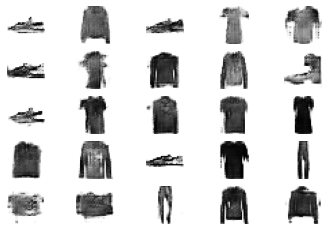

In [17]:
# Creates and displays a plot of generated images (reversed grayscale).
def display_plot(examples, n):
    for i in range(n * n):
        plt.subplot(n, n, 1 + i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

latent_points = generate_latent_points(100, 25) # Generates the latent points.
X = trained_generator.predict(latent_points) # Generates the images.
display_plot(X, 5) # Plots the result.